In [1]:
import torch
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt

from transformers import (
    CLIPProcessor,
    CLIPModel,
    BlipProcessor,
    BlipForConditionalGeneration,
)


In [2]:
clip_ckpt = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_ckpt)
clip_processor = CLIPProcessor.from_pretrained(clip_ckpt)

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device).eval()


In [3]:
blip_ckpt = "Salesforce/blip-image-captioning-large"
blip_processor = BlipProcessor.from_pretrained(blip_ckpt)
blip_model = BlipForConditionalGeneration.from_pretrained(blip_ckpt).to(device)

In [4]:
def generate_caption(image_url):
    """Fetch an image from URL, generate a BLIP caption."""
    # Fetch the image
    resp = requests.get(image_url)
    if resp.status_code != 200:
        print(f"Could not fetch image: {image_url}")
        return None
    
    image = Image.open(BytesIO(resp.content)).convert("RGB")
    
    # Prepare inputs for BLIP
    inputs = blip_processor(image, return_tensors="pt").to(device)
    
    # Generate caption
    with torch.no_grad():
        out = blip_model.generate(**inputs, max_length=50)
    caption = blip_processor.decode(out[0], skip_special_tokens=True)
    
    return image, caption


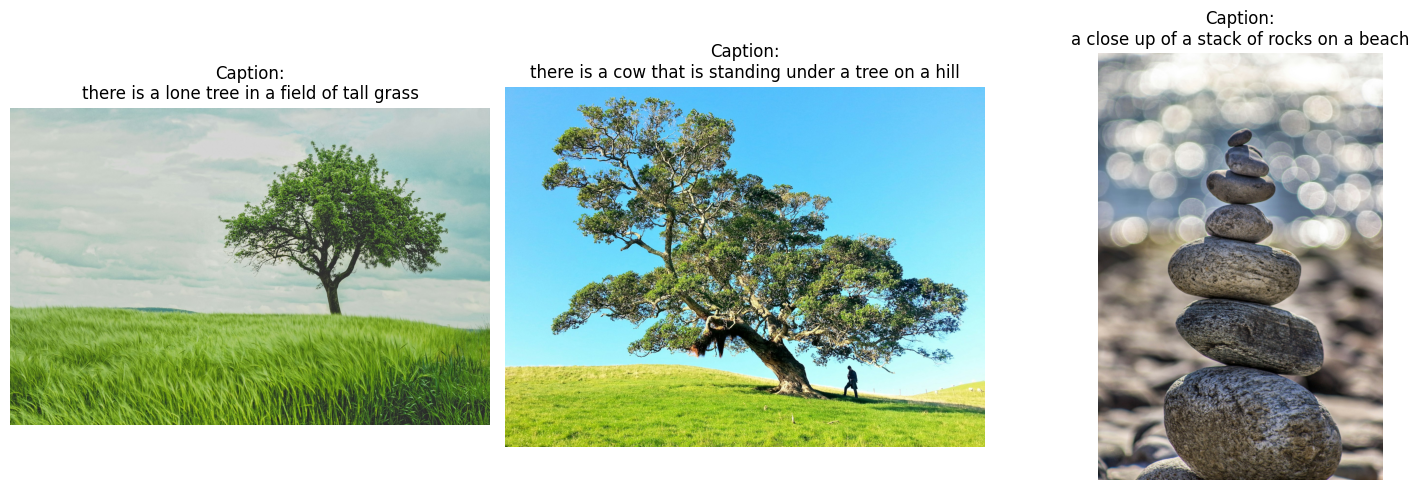

In [5]:
reference_images = [
    {
        "url": "https://images.unsplash.com/reserve/bOvf94dPRxWu0u3QsPjF_tree.jpg?q=80&w=1776&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
        "tags": ["tree", "nature"],
    },
    {
        "url": "https://images.unsplash.com/photo-1437964706703-40b90bdf563b?q=80&w=1974&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
        "tags": ["tree", "forest"],
    },
    {
        "url": "https://images.unsplash.com/photo-1444312645910-ffa973656eba?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D",
        "tags": ["rock", "outdoor"],
    },
]

num_images = len(reference_images)
fig, axes = plt.subplots(1, num_images, figsize=(5*num_images, 5))

for i, ref in enumerate(reference_images):
    image_url = ref["url"]
    image, caption = generate_caption(image_url)
    
    axes[i].imshow(image)
    axes[i].axis("off")
    # Truncate caption if it's too long for display
    axes[i].set_title(f"Caption:\n{caption[:60] + '...' if len(caption) > 60 else caption}")

plt.tight_layout()
plt.show()
